Лабораторна робота №2
Виконав: Приймак Євгеній, група КА-13

Тема: Реалiзацiя багатошарового персептрона для класифiкацiї зображень MNIST в Python з нуля засобами Numpy 

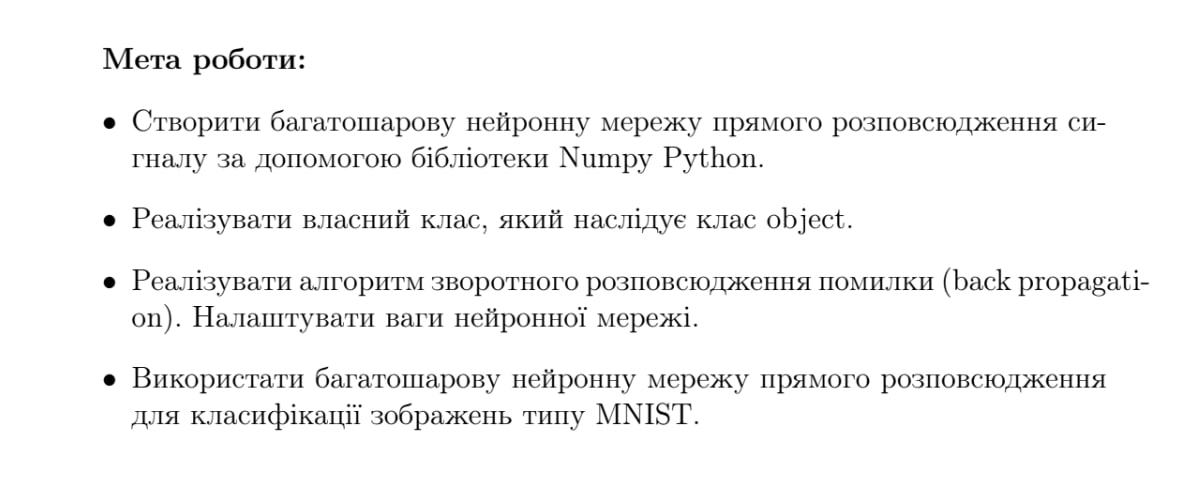

Хiд виконання роботи 
1. Завантажити простий набiр зображень згiдно з варiантом. 
2. Виконати пiдготовку даних для навчання - за необхiдностi, залежно вiд вхiдного набору. Наприклад, нормалiзувати данi тощо. 
3. За необхiдностi розбити данi на навчальну i перевiрочну множини у спiв вiдношеннi 80%: 20%. Звернути увагу, що завантаженi данi вже можуть бути розбитi на навчальну i перевiрочну множини. 
4. Побудувати базову мережу прямого розповсюдження сигналу з єдиним скритим шаром i output шаром softmax. Для створення моделi реалiзу вати власний клас, який наслiдує клас object. Ваги iнiцiалiзувати неве ликими випадковими значеннями, якi нормально розподiленi з нульовим середнiм та малою дисперсiєю. 
5. Реалiзувати алгоритм зворотного розповсюдження помилки (back propagati on). 
6. Функцiєю втрат задати перехресну ентропiю. 
1
7. Налаштувати ваги побудованої мережi реалiзованим алгоритмом back propagation. 
8. Побудувати кiлька альтернативних мереж MLP з кiлькома скритими шарами ReLU або tanh. Налаштувати їх ваги реалiзованим алгоритмом back propagation. 
9. Для кожної моделi побудувати: 
• графiки змiни значень функцiї втрат на тренувальнiй i перевiро чнiй множинах по мiрi навчання моделi, тобто залежно вiд кiлькостi епох, 
• графiки змiни показника accuracy на тренувальнiй i перевiрочнiй множинах по мiрi навчання моделi. 
10. Пiдiбрати значення гiперпараметра швидкостi навчання. 
11. Обрати для нейронiв скритих шарiв рiзнi функцiї активацiї: LeakyReLU, Parametric LeakyReLU, ELU. Спробувати з’ясувати чи впливає вибiр функцiї активацiї на: 
• час навчання мережi, 
• якiсть роботи мережi (фiнальне значення accuracy) на перевiрочнiй множинi, 
• час надання прогнозу мережею. 
12. Вiдобразити кiлька зображень, невiрно класи
iкованих моделлю. 13. Дати вiдповiдi на контрольнi питання (усно).
 перехресну ентропiю.перехресну ентропiю. перехресну ентропiю.перехресну ентропiю.

Варіант 2: Fashion MNIST, kaggle.com

In [1]:
import os
import struct
import numpy as np
 
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2
 
    return images, labels

In [3]:
X_train, y_train = load_mnist('E:/MNIST/FASHION/', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

Rows: 60000, columns: 784


In [4]:
X_test, y_test = load_mnist('E:/MNIST/FASHION/', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 10000, columns: 784


Візуалізуємо перше зображення кожного класу:

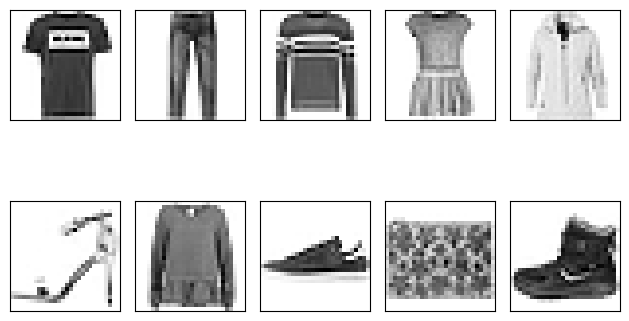

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('images/12_5.png', dpi=300)
plt.show()

Візуалізуємо 25 версій boots

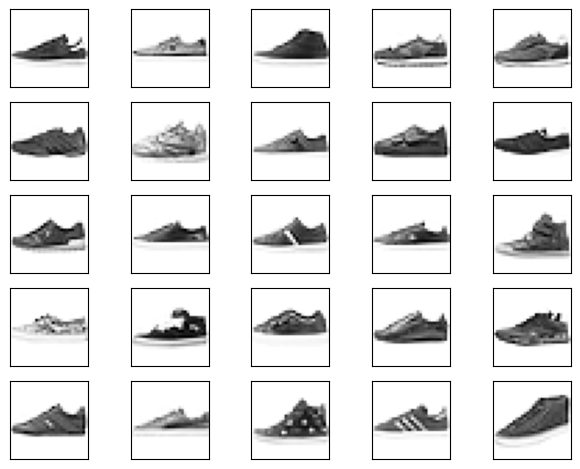

In [6]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('images/12_6.png', dpi=300)
plt.show()

In [7]:
import numpy as np

np.savez_compressed('mnist_scaled.npz', 
                    X_train=X_train,
                    y_train=y_train,
                    X_test=X_test,
                    y_test=y_test)

In [8]:
mnist = np.load('mnist_scaled.npz')
mnist.files

['X_train', 'y_train', 'X_test', 'y_test']

In [9]:
X_train, y_train, X_test, y_test = [mnist[f] for f in ['X_train', 'y_train', 
                                    'X_test', 'y_test']]

del mnist

X_train.shape

(60000, 784)

Реалізація багатошарового персептрону:

In [22]:
import numpy as np
import sys


class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_hidden : int (default: 30)
        Number of hidden units.
    l2 : float (default: 0.)
        Lambda value for L2-regularization.
        No regularization if l2=0. (default)
    epochs : int (default: 100)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatch_size : int (default: 1)
        Number of training examples per minibatch.
    seed : int (default: None)
        Random seed for initializing weights and shuffling.

    Attributes
    -----------
    eval_ : dict
      Dictionary collecting the cost, training accuracy,
      and validation accuracy for each epoch during training.

    """
    def __init__(self, n_hidden=30,
                 l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None, activation = 'relu'):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
        self.activation = activation


    def _onehot(self, y, n_classes):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_examples]
            Target values.
        n_classes : int
            Number of classes

        Returns
        -----------
        onehot : array, shape = (n_examples, n_labels)

        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _relu(self, z):
        """Compute ReLU activation function"""
        return np.maximum(0, z)

    def _leaky_relu(self, z, alpha=0.01):
        """Compute Leaky ReLU activation function"""
        return np.where(z > 0, z, alpha * z)

    def _parametric_leaky_relu(self, z, alpha=0.01, a=None):
        """Compute Parametric Leaky ReLU activation function"""
        if a is not None:
            alpha = a
        return np.where(z > 0, z, alpha * z)

    def _elu(self, z, alpha=1.0):
        """Compute ELU activation function"""
        return np.where(z > 0, z, alpha * (np.exp(z) - 1))

    def _activation(self, z):
        """Choose activation function"""
        if self.activation == 'relu':
            return self._relu(z)
        elif self.activation == 'leaky_relu':
            return self._leaky_relu(z)
        elif self.activation == 'parametric_leaky_relu':
            return self._parametric_leaky_relu(z)
        elif self.activation == 'elu':
            return self._elu(z)

    def _activation_derivative(self, z):
        """Compute derivative of activation function"""
        if self.activation == 'relu':
            return np.where(z > 0, 1, 0)
        elif self.activation == 'leaky_relu':
            return np.where(z > 0, 1, 0.01)
        elif self.activation == 'parametric_leaky_relu':
            return np.where(z > 0, 1, alpha)
        elif self.activation == 'elu':
            return np.where(z > 0, 1, alpha * np.exp(z))

    def _forward(self, X):
        """Compute forward propagation step"""

        # step 1: net input of hidden layer
        # [n_examples, n_features] dot [n_features, n_hidden]
        # -> [n_examples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h

        # step 2: activation of hidden layer
        a_h = self._sigmoid(z_h)

        # step 3: net input of output layer
        # [n_examples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_examples, n_classlabels]

        z_out = np.dot(a_h, self.w_out) + self.b_out

        # step 4: activation output layer
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_examples, n_labels)
            one-hot encoded class labels.
        output : array, shape = [n_examples, n_output_units]
            Activation of the output layer (forward propagation)

        Returns
        ---------
        cost : float
            Regularized cost

        """
        L2_term = (self.l2 *
                   (np.sum(self.w_h ** 2.) +
                    np.sum(self.w_out ** 2.)))

        term1 = -y_enc * (np.log(output + 1e-5))
        term2 = (1. - y_enc) * np.log(1. - output + 1e-5)
        cost = np.sum(term1 - term2) + L2_term
        
        
        return cost

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_examples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_examples]
            Predicted class labels.

        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(sel f,X_train, y_train, X_valid, y_valid):
        """ Learn weights from training data.

        Parameters
        -----------
        X_train : array, shape = [n_examples, n_features]
            Input layer with original features.
        y_train : array, shape = [n_examples]
            Target class labels.
        X_valid : array, shape = [n_examples, n_features]
            Sample features for validation during training
        y_valid : array, shape = [n_examples]
            Sample labels for validation during training

        Returns:
        ----------
        self

        """
        n_output = np.unique(y_train).shape[0]  # number of class labels
        n_features = X_train.shape[1]

        ########################
        # Weight initialization
        ########################

        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        # weights for hidden -> output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))

        epoch_strlen = len(str(self.epochs))  # for progress formatting
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        # iterate over training epochs
        for i in range(self.epochs):

            # iterate over minibatches
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                ##################
                # Backpropagation
                ##################

                # [n_examples, n_classlabels]
                delta_out = a_out - y_train_enc[batch_idx]

                # [n_examples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)

                # [n_examples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_examples, n_hidden]
                delta_h = (np.dot(delta_out, self.w_out.T) *
                           sigmoid_derivative_h)

                # [n_features, n_examples] dot [n_examples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, delta_h)
                grad_b_h = np.sum(delta_h, axis=0)

                # [n_hidden, n_examples] dot [n_examples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, delta_out)
                grad_b_out = np.sum(delta_out, axis=0)

                # Regularization and weight updates
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            #############
            # Evaluation
            #############

            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float64) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float64) /
                         X_valid.shape[0])

            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

In [14]:
n_epochs = 200

In [15]:
nn = NeuralNetMLP(n_hidden=100, 
                  l2=0.01, 
                  epochs=n_epochs, 
                  eta=0.0005,
                  minibatch_size=100, 
                  shuffle=True,
                  seed=1)

nn.fit(X_train=X_train[:55000], 
       y_train=y_train[:55000],
       X_valid=X_train[55000:],
       y_valid=y_train[55000:])

200/200 | Cost: 17781.32 | Train/Valid Acc.: 94.88%/89.22% 

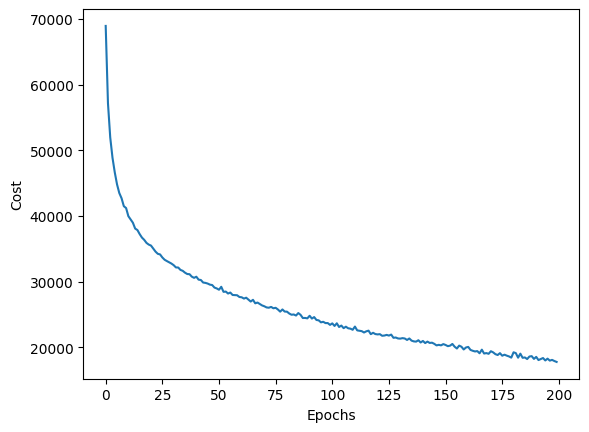

In [17]:
import matplotlib.pyplot as plt


plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.savefig('E:/MNIST/images/cost_epochs.png', dpi=300)
plt.show()

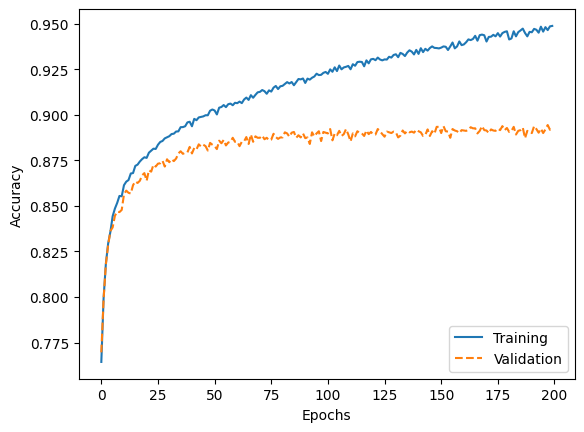

In [18]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='Training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='Validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.savefig('E:/MNIST/images/accur_epochs.png', dpi=300)
plt.show()

In [20]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred)
       .astype(np.float64) / X_test.shape[0])

print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 88.25%


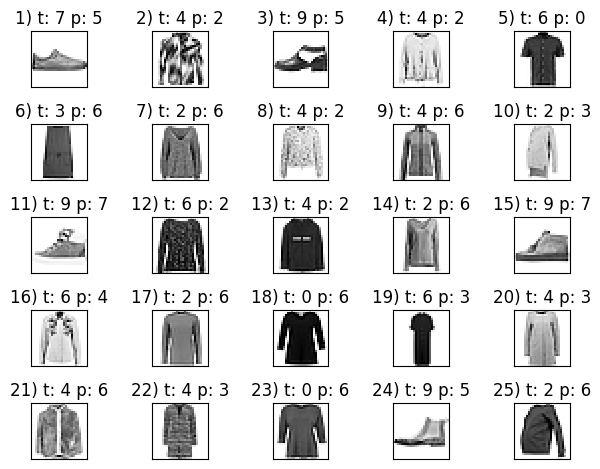

In [21]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.savefig('E:/MNIST/images/miscl_images.png', dpi=300)
plt.show()

Спробуємо різні функції активації для скритого шару:

200/200 | Cost: 17781.32 | Train/Valid Acc.: 94.88%/89.22% 

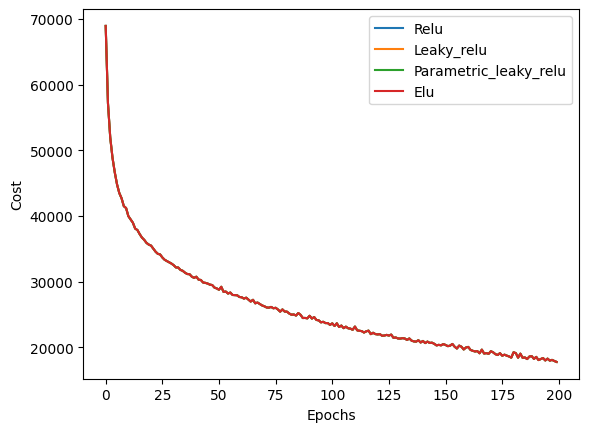

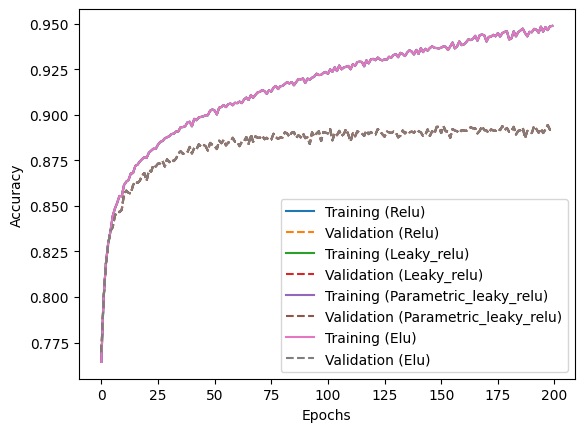

In [23]:
# Задаємо параметри та навчаємо моделі
n_epochs = 200

activations = ['relu', 'leaky_relu', 'parametric_leaky_relu', 'elu']
models = {}

for activation in activations:
    nn = NeuralNetMLP(n_hidden=100, 
                      l2=0.01, 
                      epochs=n_epochs, 
                      eta=0.0005,
                      minibatch_size=100, 
                      shuffle=True,
                      seed=1,
                      activation=activation)
    
    nn.fit(X_train=X_train[:55000], 
           y_train=y_train[:55000],
           X_valid=X_train[55000:],
           y_valid=y_train[55000:])
    
    models[activation] = nn

# Графіки та фінальна точність
for activation, nn in models.items():
    plt.plot(range(nn.epochs), nn.eval_['cost'], label=f'{activation.capitalize()}')

plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.savefig('E:/MNIST/images/cost_epochs_comparison.png', dpi=300)
plt.show()

for activation, nn in models.items():
    plt.plot(range(nn.epochs), nn.eval_['train_acc'], label=f'Training ({activation.capitalize()})')
    plt.plot(range(nn.epochs), nn.eval_['valid_acc'], label=f'Validation ({activation.capitalize()})', linestyle='--')

plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.savefig('E:/MNIST/images/accur_epochs_comparison.png', dpi=300)
plt.show()

Отримуємо аналогічний результат, отже різні функції активації для даного набору не впливають на точність, хоча й помітно варіюються в часі виконання (ReLU, LeakyReLU, ParametricLeakyReLU ~3хв, ELU ~4хв) - ймовірно через обчислення експоненти в ELU. 